In [182]:
import os
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import scipy.stats as stats

In [183]:
#os.chdir('C:/Users/Jason/Documents/Data Science/Fall 2019/Baysian Machine Learning/Project')

In [184]:
ed_data = pd.read_csv('ed_data_final.csv') 
ed_data = ed_data.iloc[:,1:10] #removing the first index row
ed_data.head()

,School,Year,schoolyear,Race,Gender,Disadvantaged,ESOL,Disabled,Passed
0,Albemarle,2010,1,Black,Female,0,0,0,1
1,Albemarle,2010,1,Black,Female,0,0,0,1
2,Albemarle,2010,1,Black,Female,0,0,0,1
3,Albemarle,2010,1,Black,Female,0,0,0,1
4,Albemarle,2010,1,Black,Female,0,0,0,1


In [185]:
#preparing the data for analysis
passed = ed_data.iloc[:,8] #creating a variable for the exam results
replace_map = {'schoolyear': {40:0}} 
ed_data = ed_data.replace(replace_map) #turning the years into categorical variables
schoolyear = np.array(tuple(ed_data['schoolyear'])) #turning the school/year combination into an array
cols_to_drop = ['Year', 'Passed', 'School', 'schoolyear'] #dropping year, school and exam results from the main dataset since they are being stored separately
ed_data = ed_data.drop(cols_to_drop, axis=1)

In [186]:
#making the first two columns into dummies
test = []
for i in range(0,2): 
    test.append(pd.get_dummies(ed_data.iloc[:,i]))

dummies = test[0] 
for i in range(1,2): #combining all of the dummy variables into a single dataframe
    dummies = pd.concat([dummies, test[i]], axis=1)
dummies.head()

,Black,Hispanic,Other,White,Female,Male
0,1,0,0,0,1,0
1,1,0,0,0,1,0
2,1,0,0,0,1,0
3,1,0,0,0,1,0
4,1,0,0,0,1,0


In [187]:
cols_to_drop = ['Race', 'Gender'] 
ed_data = ed_data.drop(cols_to_drop, axis=1) 

ed_data = pd.concat([ed_data, dummies], axis=1)
ed_data.head()

,Disadvantaged,ESOL,Disabled,Black,Hispanic,Other,White,Female,Male
0,0,0,0,1,0,0,0,1,0
1,0,0,0,1,0,0,0,1,0
2,0,0,0,1,0,0,0,1,0
3,0,0,0,1,0,0,0,1,0
4,0,0,0,1,0,0,0,1,0


In [188]:
#dropping one dummy for each of the categoricals so we can more easily compare relative results 
cols_to_drop = ['Female', 'White'] 
ed_data = ed_data.drop(cols_to_drop, axis=1) 
ed_data.head()

,Disadvantaged,ESOL,Disabled,Black,Hispanic,Other,Male
0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0


## Hierarchical 

In [189]:
#preparing the data for the unpooled model / hierarchical
disadv = tuple(ed_data['Disadvantaged'])
disabled = tuple(ed_data['Disabled'])
ESOL = tuple(ed_data['ESOL'])
black = tuple(ed_data['Black'])
hispanic = tuple(ed_data['Hispanic'])
other = tuple(ed_data['Other'])
male = tuple(ed_data['Male'])

In [132]:
with Model() as hi_model:
    mu = pm.Normal('mu', mu=0, sd=1)
    sigma = pm.HalfCauchy('sigma', 1)

    #model paramaters that will vary by school/year
    alpha = pm.Normal('alpha',mu=0,sd=1, shape=40)
    Beta1 = pm.Normal('Beta1',0, sd=1, shape=40)
    Beta2 = pm.Normal('Beta2',0, sd=1, shape=40)
    Beta3 = pm.Normal('Beta3',0, sd=1, shape=40)
    Beta4 = pm.Normal('Beta4',mu, sd=sigma, shape=40)
    Beta5 = pm.Normal('Beta5',0, sd=1, shape=40)
    Beta6 = pm.Normal('Beta6',0, sd=1, shape=40)
    Beta7 = pm.Normal('Beta7',0, sd=1, shape=40)
    
    #model formula
    theta = alpha[schoolyear] + Beta1[schoolyear]*disadv + Beta2[schoolyear]*ESOL +Beta3[schoolyear]*disabled+ Beta4[schoolyear]*black+ Beta5[schoolyear]*hispanic+Beta6[schoolyear]*other+Beta7[schoolyear]*male
    p = 1 / (1+ np.exp(-theta))
    y = pm.Binomial('y', n=1, p=p, observed=passed)

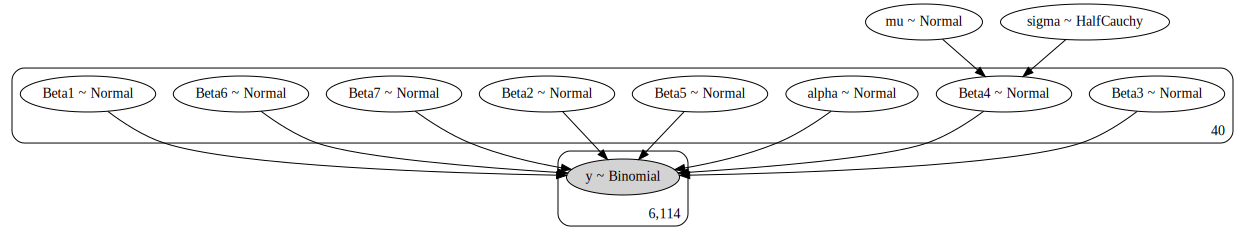

In [134]:
#pm.model_to_graphviz(hi_model) #commented out for rerunning

In [9]:
with hi_model:
    hi_approx = pm.fit(15000, method = 'advi')

Average Loss = 2,698.3: 100%|██████████| 15000/15000 [00:46<00:00, 325.39it/s]
Finished [100%]: Average Loss = 2,698.2


In [ ]:
#pulling out the means and sds
mu_4 = hi_approx.mean.eval()
std_4 = hi_approx.std.eval()

In [195]:
#note: I didn't actually run the ELBO plot (it was causing weird errors for some reason), but we did confirm convergence viewing the average loss as the function ran

In [14]:
#sampling using the VI estimates obtained
hi_trace = hi_approx.sample(20000)
hi_results = pm.summary(hi_trace)
#hi_results.to_csv('hi_full_results.csv') #ran this code on rivanna, saved the output, and then loaded it on my computer for further analysis

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 20000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

## Unpooled Model

In [135]:
with Model() as unpooled_model:
    #model paramaters that will vary by school/year
    alpha = pm.Normal('alpha',mu=0,sd=1, shape=40)
    Beta1 = pm.Normal('Beta1',0, sd=1, shape=40)
    Beta2 = pm.Normal('Beta2',0, sd=1, shape=40)
    Beta3 = pm.Normal('Beta3',0, sd=1, shape=40)
    Beta4 = pm.Normal('Beta4',0, sd=1, shape=40)
    Beta5 = pm.Normal('Beta5',0, sd=1, shape=40)
    Beta6 = pm.Normal('Beta6',0, sd=1, shape=40)
    Beta7 = pm.Normal('Beta7',0, sd=1, shape=40)
    
    #model formula
    theta = alpha[schoolyear] + Beta1[schoolyear]*disadv + Beta2[schoolyear]*ESOL +Beta3[schoolyear]*disabled+ Beta4[schoolyear]*black+ Beta5[schoolyear]*hispanic+Beta6[schoolyear]*other+Beta7[schoolyear]*male
    p = 1 / (1+ np.exp(-theta))
    y = pm.Binomial('y', n=1, p=p, observed=passed)

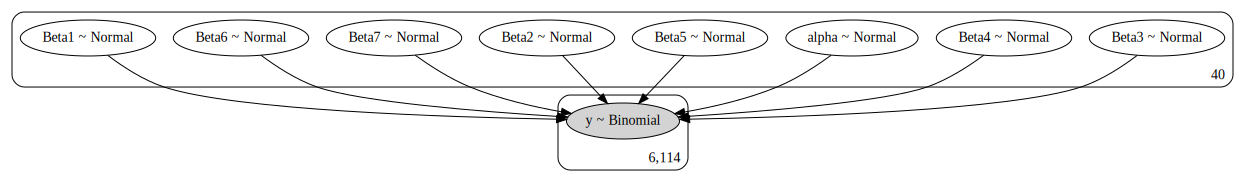

In [136]:
#pm.model_to_graphviz(unpooled_model) commented out for rerunning

In [18]:
with unpooled_model:
    un_approx = pm.fit(15000, method = 'advi')

Average Loss = 2,703.8: 100%|██████████| 15000/15000 [00:45<00:00, 326.63it/s]
Finished [100%]: Average Loss = 2,703.8


In [196]:
#note: I didn't actually run the ELBO plot (it was causing weird errors for some reason), but we did confirm convergence viewing the average loss as the function ran

In [ ]:
#sampling using the estimates from VI
un_trace = un_approx.sample(20000)
un_results = pm.summary(un_trace)

In [21]:
#un_trace.to_csv('un_full_results.csv') #ran this code on rivanna, saved the output, and then loaded it on my computer for further analysis

## Analysis

In [198]:
#As noted above, VI code was run on Rivanna, and then exported to .csv and then reloaded on my computer
un_results = pd.read_csv('un_full_results.csv')
un_results.head()
hi_results = pd.read_csv('hi_full_results.csv')
hi_results.head()

,Unnamed: 0,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,alpha[0],1.593,0.256,1.131,2.093,0.002,0.001,19740,19740,19731,19904,NaN
1,alpha[1],2.649,0.336,2.004,3.257,0.002,0.002,20093,20093,20097,19564,NaN
2,alpha[2],3.053,0.354,2.383,3.707,0.003,0.002,20011,20011,20007,19836,NaN
3,alpha[3],1.959,0.227,1.534,2.385,0.002,0.001,19039,18998,19040,18288,NaN
4,alpha[4],1.738,0.195,1.384,2.113,0.001,0.001,19642,19631,19646,19355,NaN


In [199]:
labels = pd.read_csv('labels.csv') #adding labels to help navigate the data easier
un_results = pd.concat([labels,un_results], axis=1)
un_results.head()

,School_Year,Variable,Unnamed: 0,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,Western 2019,Intercept,alpha[0],1.576,0.254,1.100,2.050,0.002,0.001,19832.0,19800.0,19827.0,19592.0,NaN
1,Albemarle 2010,Intercept,alpha[1],2.667,0.338,2.015,3.288,0.002,0.002,19911.0,19911.0,19916.0,20237.0,NaN
2,Albemarle 2011,Intercept,alpha[2],3.082,0.357,2.398,3.738,0.003,0.002,19882.0,19799.0,19882.0,19832.0,NaN
3,Albemarle 2012,Intercept,alpha[3],1.986,0.225,1.560,2.412,0.002,0.001,19988.0,19801.0,19999.0,19591.0,NaN
4,Albemarle 2013,Intercept,alpha[4],1.744,0.199,1.371,2.118,0.001,0.001,19545.0,19545.0,19542.0,20254.0,NaN


In [200]:
labels = pd.read_csv('labels.csv')
hi_results = pd.concat([labels,hi_results], axis=1)
hi_results.head()

,School_Year,Variable,Unnamed: 0,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,Western 2019,Intercept,alpha[0],1.593,0.256,1.131,2.093,0.002,0.001,19740,19740,19731,19904,NaN
1,Albemarle 2010,Intercept,alpha[1],2.649,0.336,2.004,3.257,0.002,0.002,20093,20093,20097,19564,NaN
2,Albemarle 2011,Intercept,alpha[2],3.053,0.354,2.383,3.707,0.003,0.002,20011,20011,20007,19836,NaN
3,Albemarle 2012,Intercept,alpha[3],1.959,0.227,1.534,2.385,0.002,0.001,19039,18998,19040,18288,NaN
4,Albemarle 2013,Intercept,alpha[4],1.738,0.195,1.384,2.113,0.001,0.001,19642,19631,19646,19355,NaN


In [201]:
#un_results.to_csv('un_labeled.csv')
#hi_results.to_csv('hi_labeled.csv')

#### Comparing Unpooled to Hierarchical Model

In [202]:
mean_diff = [un_results.iloc[:,3]-hi_results.iloc[:,3]] #calculating the difference b/w means in HI and unpooled

In [203]:
#picking out the race categories for comparison
school_labels = hi_results.iloc[160:280,0] 
race_labels = hi_results.iloc[160:280,1]
means = mean_diff[0][160:280] 

In [204]:
#putting the race differences into a dataframe
diff_dict = {"School_Year":school_labels, "Race":race_labels, "Difference":means}
differences = pd.DataFrame(diff_dict)
differences['Difference'] = abs(differences['Difference']) #turning the difference into an absolute value

#splitting up school and year into separate columns (helpful for the chart labels)
new=differences["School_Year"].str.split(" ", n = 1, expand = True) 
differences['School'] = new[0]
differences['Year'] = new[1]

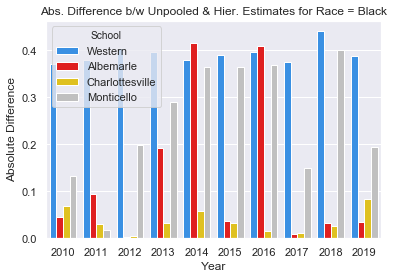

In [205]:
#creating a chart showing differences
sns.set_palette("muted")
colors = {"Albemarle":"red", "Charlottesville":"gold","Monticello":"silver","Western":"dodgerblue"}
ax = sns.barplot(x=differences.iloc[0:40,4], y=differences.iloc[0:40,2], hue=differences.iloc[0:40,3], palette=colors)
ax.set = ax.set(ylabel='Absolute Difference')
ax.set_title('Abs. Difference b/w Unpooled & Hier. Estimates for Race = Black')
plt.show()

In [206]:
#graphing credible intervals 
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
chs = hi_results.iloc[171:181,:]
alb = hi_results.iloc[161:171]
mont = hi_results.iloc[181:191]
mont

,School_Year,Variable,Unnamed: 0,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
181,Monticello 2010,Black,Beta4[21],-0.449,0.491,-1.399,0.441,0.004,0.003,18717,18717,18714,18910,NaN
182,Monticello 2011,Black,Beta4[22],-0.790,0.506,-1.746,0.148,0.004,0.003,20070,19666,20067,19409,NaN
183,Monticello 2012,Black,Beta4[23],-0.281,0.560,-1.389,0.716,0.004,0.003,19429,19429,19451,19116,NaN
184,Monticello 2013,Black,Beta4[24],-0.019,0.527,-0.996,0.975,0.004,0.003,19550,19550,19548,20051,NaN
185,Monticello 2014,Black,Beta4[25],-0.387,0.797,-1.855,1.148,0.006,0.004,20254,19890,20256,20002,NaN
186,Monticello 2015,Black,Beta4[26],-0.385,0.800,-1.835,1.187,0.006,0.004,19871,19512,19870,19641,NaN
187,Monticello 2016,Black,Beta4[27],-0.382,0.789,-1.867,1.087,0.006,0.004,19601,19315,19619,19472,NaN
188,Monticello 2017,Black,Beta4[28],-0.487,0.573,-1.567,0.591,0.004,0.003,19084,19084,19075,19038,NaN
189,Monticello 2018,Black,Beta4[29],-0.388,0.808,-1.922,1.123,0.006,0.004,20184,20170,20185,19653,NaN
190,Monticello 2019,Black,Beta4[30],-0.354,0.537,-1.344,0.662,0.004,0.003,20304,20240,20275,19154,NaN


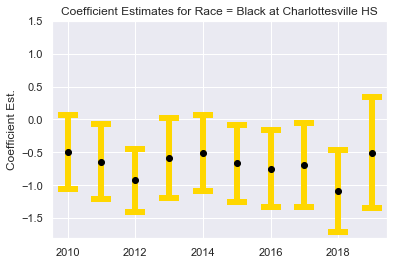

In [207]:
sns.set()
ax = plt.errorbar(years, chs['mean'], yerr=(chs['sd'])*2, fmt='o', color='black',
             ecolor='gold', elinewidth=6, capsize=10, capthick=6)
plt.ylabel('Coefficient Est.')
plt.title('Coefficient Estimates for Race = Black at Charlottesville HS')
plt.ylim(top=1.5)
plt.show()

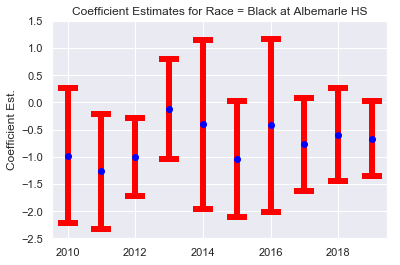

In [214]:
sns.set()
ax = plt.errorbar(years, alb['mean'], yerr=(alb['sd'])*2, fmt='o', color='blue',
             ecolor='red', elinewidth=6, capsize=10, capthick=6)
plt.ylabel('Coefficient Est.')
plt.title('Coefficient Estimates for Race = Black at Albemarle HS')
plt.ylim(top=1.5)
plt.show()

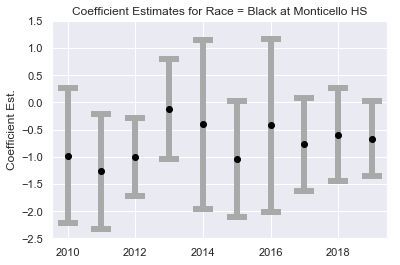

In [209]:
sns.set()
ax = plt.errorbar(years, alb['mean'], yerr=(alb['sd'])*2, fmt='o', color='black',
             ecolor='darkgrey', elinewidth=6, capsize=10, capthick=6)
plt.ylabel('Coefficient Est.')
plt.title('Coefficient Estimates for Race = Black at Monticello HS')
plt.ylim(top=1.5)
plt.show()